# ImageProcssing By Mel_spectogram
(여기는 모종의 이유로 다시 실행하면 복잡해져서 결과셀 에러나도 남겨두었음 코드상에는 에러없고 내가 전에 다른 구글드라이브에서 이 ipynb 옮겨쓰느라 삑난거)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 경로 설정
logging_path = "/content/drive/MyDrive/Colab Notebooks/인지텀프/DATA/Dataset_For_Training/LOGGING"
non_logging_path = "/content/drive/MyDrive/Colab Notebooks/인지텀프/DATA/Dataset_For_Training/NON-LOGGING"

# 이미지 저장 경로 설정
output_logging_path = "/content/drive/MyDrive/Colab Notebooks/인지텀프/mel_Images/LOGGING"
output_non_logging_path = "/content/drive/MyDrive/Colab Notebooks/인지텀프/mel_Images/NON-LOGGING"

# 멜 스펙트로그램을 생성하는 함수
def save_mel_spectrogram_image(audio_path, output_path):
    y, sr = librosa.load(audio_path, sr=None)

    # 멜 스펙트로그램 계산
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

    # 로그 변환하여 스펙트로그램의 가시성 향상
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # 그래프 그리기
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {os.path.basename(audio_path)}")
    plt.tight_layout()

    # 이미지 저장
    image_path = os.path.join(output_path, os.path.basename(audio_path).replace(".wav", ".png"))
    plt.savefig(image_path)
    plt.close()

# LOGGING 데이터 처리
for file_name in os.listdir(logging_path):
    if file_name.endswith(".wav"):
        file_path = os.path.join(logging_path, file_name)
        save_mel_spectrogram_image(file_path, output_logging_path)

# NON-LOGGING 데이터 처리
for file_name in os.listdir(non_logging_path):
    if file_name.endswith(".wav"):
        file_path = os.path.join(non_logging_path, file_name)
        save_mel_spectrogram_image(file_path, output_non_logging_path)

print("Mel Spectrogram 이미지 생성 및 저장이 완료되었습니다!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/인지텀프/DATA/Dataset_For_Training/LOGGING'

# Data Split

In [ ]:
import os
import shutil
import random

output_logging_path = "/content/drive/MyDrive/Colab Notebooks/인지텀프/mel_Images/LOGGING"
output_non_logging_path = "/content/drive/MyDrive/Colab Notebooks/인지텀프/mel_Images/NON-LOGGING"

# Train, Validation, Test 데이터 저장 경로 설정
base_output_path = "/content/drive/MyDrive/Colab Notebooks/인지텀프/Split_Data"
train_path = os.path.join(base_output_path, "Train")
val_path = os.path.join(base_output_path, "Validation")
test_path = os.path.join(base_output_path, "Test")

# 레이블 별로 디렉토리 생성
for path in [train_path, val_path, test_path]:
    os.makedirs(os.path.join(path, "LOGGING"), exist_ok=True)
    os.makedirs(os.path.join(path, "NON-LOGGING"), exist_ok=True)

# 파일 나누기 함수
def split_data(source_path, train_count, val_count, test_count, label):
    # 파일 리스트 가져오기
    files = [f for f in os.listdir(source_path) if f.endswith(".png")]
    random.shuffle(files)  # 랜덤 섞기

    # 데이터 나누기
    train_files = files[:train_count]
    val_files = files[train_count:train_count + val_count]
    test_files = files[train_count + val_count:train_count + val_count + test_count]

    # 파일 복사
    for file_name in train_files:
        shutil.copy(os.path.join(source_path, file_name), os.path.join(train_path, label, file_name))
    for file_name in val_files:
        shutil.copy(os.path.join(source_path, file_name), os.path.join(val_path, label, file_name))
    for file_name in test_files:
        shutil.copy(os.path.join(source_path, file_name), os.path.join(test_path, label, file_name))

# LOGGING 데이터 나누기
split_data(output_logging_path, 420, 52, 52, "LOGGING")

# NON-LOGGING 데이터 나누기
split_data(output_non_logging_path, 420, 52, 52, "NON-LOGGING")

print("Train, Validation, Test 데이터 생성 및 저장이 완료되었습니다!")

Train, Validation, Test 데이터 생성 및 저장이 완료되었습니다!


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input, Conv2D, LSTM, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 경로 설정
train_dir = '/content/drive/MyDrive/Colab Notebooks/인지텀프/Split_Data/Split_Data/Train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/인지텀프/Split_Data/Split_Data/Validation'

# 이미지 전처리 및 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# ResNet50V2를 기반으로 한 전이학습 RCNN 모델
def create_rcnn_model(input_shape=(224, 224, 3), num_lstm_units=128):
    # ResNet50V2 기본 모델 로드 (사전 훈련된 가중치 포함)
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # 기본 모델의 가중치 고정

    # 모델 아키텍처 정의
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # LSTM 레이어 추가
    x = tf.keras.layers.Reshape((1, x.shape[1]))(x)
    x = LSTM(num_lstm_units, return_sequences=False)(x)

    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# 모델 생성 및 컴파일
model = create_rcnn_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

# 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/인지텀프/best_rcnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# 모델 훈련
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)


Found 840 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 230s 7s/step - accuracy: 0.5377 - loss: 0.6871 - recall: 0.7143 - val_accuracy: 0.7404 - val_loss: 0.6236 - val_recall: 0.7115
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 786ms/step - accuracy: 0.6936 - loss: 0.6042 - recall: 0.6150 - val_accuracy: 0.8269 - val_loss: 0.5502 - val_recall: 0.9808
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 811ms/step - accuracy: 0.7914 - loss: 0.5274 - recall: 0.8548 - val_accuracy: 0.8558 - val_loss: 0.4895 - val_recall: 0.8462
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 724ms/step - accuracy: 0.7982 - loss: 0.4805 - recall: 0.7489 - val_accuracy: 0.8558 - val_loss: 0.4465 - val_recall: 0.9231
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 735ms/step - accuracy: 0.8248 - loss: 0.4477 - recall: 0.8212 - val_accuracy: 0.8654 - val_loss: 0.4123 - val_recall: 0.9231
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 763ms/step - accuracy: 0.8419 - loss: 0.3963 - recall: 0.8875 - val_accuracy: 0.8269 - val_loss: 0.3905 - val_recall: 0.7692
Epoch 

# Acc, Recall Graph

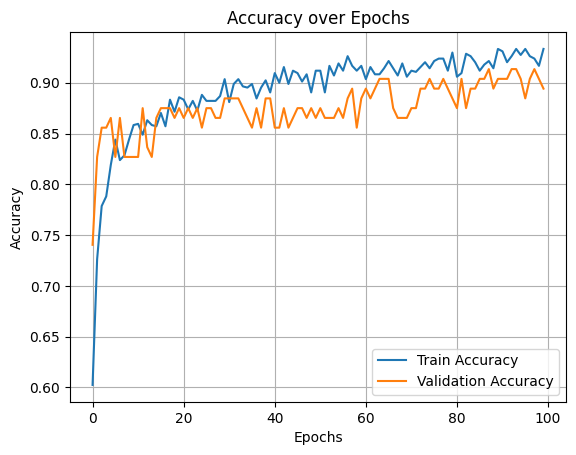

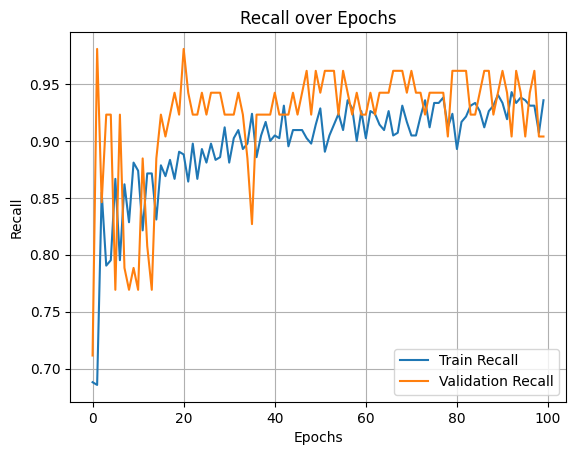

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Recall 메트릭 계산 함수
class RecallCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.validation_data[0]) > 0.5).astype(int)
        val_targ = self.validation_data[1]
        recall = recall_score(val_targ, val_predict)
        logs['val_recall'] = recall
        print(f"\nEpoch {epoch+1}: val_recall: {recall:.4f}")

# History로부터 accuracy와 val_accuracy 그래프 그리기
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# History로부터 recall 그래프 그리기
def plot_recall(history):
        plt.plot(history.history['recall'], label='Train Recall')
        plt.plot(history.history['val_recall'], label='Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.title('Recall over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()


# 그래프 그리기
plot_accuracy(history)
plot_recall(history)

# Evaluation with F1 score and acc

In [5]:

# 모델 평가
test_dir = '/content/drive/MyDrive/Colab Notebooks/인지텀프/Split_Data/Split_Data/Test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_loss, test_accuracy, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 모델 저장
model.save('/content/drive/MyDrive/Colab Notebooks/인지텀프/final_rcnn_model.keras')

Found 104 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.9276 - loss: 0.1967 - recall: 0.7221
Test Accuracy: 92.31%


In [6]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

# 테스트 데이터 예측
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # 0.5를 기준으로 이진 분류

# 실제 라벨 가져오기
y_true = test_generator.classes

# F1-Score 계산
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}")

# Classification Report 출력
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 670ms/step
F1-Score: 0.9216
Classification Report:
               precision    recall  f1-score   support

     LOGGING       0.91      0.94      0.92        52
 NON-LOGGING       0.94      0.90      0.92        52

    accuracy                           0.92       104
   macro avg       0.92      0.92      0.92       104
weighted avg       0.92      0.92      0.92       104



# Making Confusion Matrix

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 모델 로드
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/인지텀프/final_rcnn_model.keras')


In [8]:
# 예측 생성
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)  # 0 또는 1로 변환

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 680ms/step


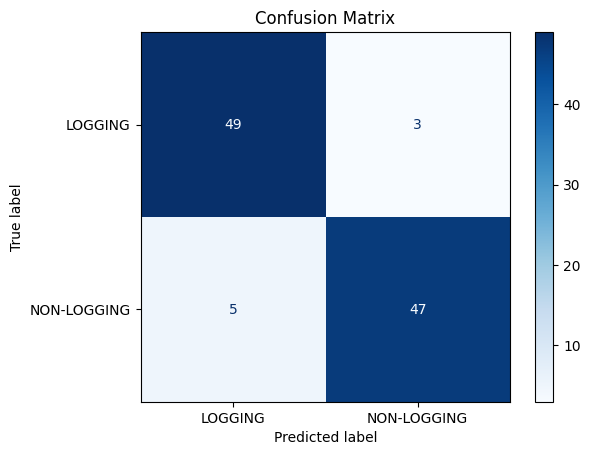

In [9]:
# 실제 레이블 가져오기
true_classes = test_generator.classes

# Confusion Matrix 계산
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())

# Confusion Matrix 시각화
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
